- Plot earliest divergence points taking into account later AUC differences too
- Rekha Varrier 2021

TO DO: EDIT CODE TO REMOVE FIXATION PTS FROM THE FMRI DATA BEFORE COMPARING TIMECOURSES 


In [1]:
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [7]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'



In [8]:
# vid names as saved in behavioral data

vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", 
            "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]



In [9]:
#loading shen atlas labels

pd.set_option('display.max_colwidth', None) # so columns are not snipped

# loading the Shen atlas labels
shen268 = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))

shen268.head()

# to print an ROI: eval(shen268[str(insert ROI val between 1-268)][0])['name']

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}","{'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}","{'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}","{'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}","{'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}","{'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}","{'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}","{'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}","{'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}","{'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}",...,"{'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}","{'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}","{'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}","{'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}","{'coords': [-4.68474576271187, -10.2406779661017, 5.877966101694909], 'name': '82.71% Left_Thalamus; 13.90% Left_Lateral_Ventrical'}","{'coords': [-11.407792207792212, -25.563636363636363, 14.883116883116884], 'name': '61.82% Left_Thalamus; 31.43% Left_Lateral_Ventrical'}","{'coords': [-4.821052631578951, -21.51157894736842, -15.890526315789472], 'name': '71.16% Brain-Stem; 25.89% no_label'}","{'coords': [-4.227272727272734, -37.89772727272728, -53.26704545454545], 'name': '100.00% Brain-Stem'}","{'coords': [-6.9375, -33.13068181818181, -39.34659090909091], 'name': '99.15% Brain-Stem'}","{'coords': [-5.697885196374628, -18.966767371601208, -36.81570996978852], 'name': '100.00% Brain-Stem'}"


In [10]:
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses.shape

(1048, 10)

In [ ]:
#### 1. PAN-MOVIES ANALYSIS
#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')
tcs_trial_all_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_trial_all_z.shape)

tcs_trial_resh_yes = []
tcs_trial_resh_no = []


for m in range(10):
    tcs_trial_resh_yes.append(tcs_trial_all_z[responses[:,m]==1,:,:,m])# subsm * 268 * 32
    tcs_trial_resh_no.append(tcs_trial_all_z[responses[:,m]==0,:,:,m])# subsm * 268 * 32

tcs_trial_resh_yes = np.concatenate(tcs_trial_resh_yes,axis=0)
tcs_trial_resh_no = np.concatenate(tcs_trial_resh_no,axis=0)
print('Across movies: \n\tyes:'+ str(tcs_trial_resh_yes.shape) + ',no:' + str(tcs_trial_resh_no.shape))


'''#### PAN-MOVIES ANALYSIS MATCHED (this makes more sense if we want to di a t-test to compare groups since we at least match the nr of yes/no responses)
#select subs who responded "social" to the yes movie and nonsocial to the no movie
pop_responses = [1,0,0,1,0,1,1,0,1,0]
subsList = []
for s in range(responses.shape[0]):
    if list(responses[s,:]) == pop_responses:
        subsList.append(s)
print('num subs showing pop responses:', len(subsList))

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')

print('before:',tcs_trial_all_z.shape)

tcs_trial_resh_yes_matched = []
tcs_trial_resh_no_matched = []


for m in range(10):
    if pop_responses[m] == 1:
        tcs_trial_resh_yes_matched.append(tcs_trial_all_z[subsList,:,:,m])# subsList * 268 * 32
    elif pop_responses[m] == 0:
        tcs_trial_resh_no_matched.append(tcs_trial_all_z[subsList,:,:,m])# subsList * 268 * 32

tcs_trial_resh_yes_matched = np.concatenate(tcs_trial_resh_yes_matched,axis=0)
tcs_trial_resh_no_matched  = np.concatenate(tcs_trial_resh_no_matched,axis=0)
print('Across movies: \n\tyes:'+ str(tcs_trial_resh_yes_matched.shape) + ',no:' + str(tcs_trial_resh_no_matched.shape))

## caution: this is still not fully matched - just that both groups have the same subjects so we know the variance is shared.
#  Each subject is repeated within a group too.
# to do: is there a better way to do this? guess this can be compared to the block analysis of multiple stimuli'''

In [11]:
# load fmri data

#### 2. SAME MOVIE/DIFFERENT SUBJECTS ANALYSIS. run-wise normalized data, so we restore amplitude differences

print('run-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_zscorenorm.npy')
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('dims:',tcs_run_z.shape)

fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_maxminnorm.npy')
tcs_run_maxmin = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


movie_ind_same = 4 # CHANGE MOVIE INDEX HERE - FOR WITHIN-MOVIE ANALYSES
print('movie: ' + str(vidnames[movie_ind_same]))
subs1 = np.where(responses[:,movie_ind_same] == 1)[0]
subs2 = np.where(responses[:,movie_ind_same] == 0)[0] 
print('nr of subs for movie:' + str(movie_ind_same) + '. Yes responders' + str(subs1.shape) + ',No responders' + str(subs2.shape))

# same movie, old version with 14 extra TRs
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_maxminnorm_extra14TRs.npy')
tcs14_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


run-wise norm data.
dims: (1048, 268, 56, 10)
movie: Random mechanical
nr of subs for movie:4. Yes responders(88,),No responders(587,)


In [12]:
#### 3. DIFFERENT MOVIES ANALYSIS
#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')
tcs_trial_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_trial_z.shape)

fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_maxminnorm.npy')
tcs_trial_maxmin = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


movie_ind_yes = 0 # CHANGE MOVIE IND HERE - SOCIAL
movie_ind_no = 1 # CHANGE MOVIE IND HERE - NONSOCIAL
print('"social" movie: ' + str(vidnames[movie_ind_yes]))
print('"nonsocial" movie: ' + str(vidnames[movie_ind_no]))

subs = np.where((responses[:,movie_ind_yes] == 1)&(responses[:,movie_ind_no] == 0))[0] 
print('nr of subs with yes for movie ' + str(movie_ind_yes) + ' and no for movie ' + str(movie_ind_no) + ' =' + str(subs.shape))

tcs_trial_z = tcs_trial_z[subs,:,:,:]
tcs_trial_maxmin = tcs_trial_maxmin[subs,:,:,:]
print('after:',tcs_trial_z.shape)



trial-wise norm data.
before: (1048, 268, 56, 10)
"social" movie: COAXING-B
"nonsocial" movie: BILLIARD-A
nr of subs with yes for movie 0 and no for movie 1 =(870,)
after: (870, 268, 56, 10)


In [10]:
tr0_ind = 3 # ind at which tr=0 starts

In [11]:
from importlib import reload  
import ttests_movie_tcs as tmt # contains  ttest_diffmovies, ttest_samemovies
reload(tmt) # reload if the module/.py file is changed


<module 'ttests_movie_tcs' from '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code/on GitHub/exploration_earliest_timecourses_divergence_types/ttests_movie_tcs.py'>

## Timepoint at which earliest difference emerges

In [13]:
ts = np.load(os.path.join(data_file_loc,'earliest_pt_div_allmovies.npy'),allow_pickle=True)
ts

array([[array([10, 11, 14, 15, 26]), array([-1., -1., -1., -1.,  1.])],
       [array([17, 19, 20, 21, 22, 23, 24, 25]),
        array([1., 1., 1., 1., 1., 1., 1., 1.])],
       [array([], dtype=int64), array([], dtype=float64)],
       [array([13, 16]), array([-1., -1.])],
       [array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26,
       27]),
        array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.])],
       [array([ 5, 10, 11, 12, 13, 14, 15, 22, 23, 24, 25, 26, 27]),
        array([ 1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.])],
       [array([ 3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21]),
        array([ 1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.])],
       [array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27]),
        array([-1., -1., -1., -1., -1., -1.

In [ ]:
# save timept at which earliest diff emerges
#ALL MOVIES
earliest_pt_all = np.empty((268,))
earliest_pt_all [:] = np.nan
sign_earliest_pt_all  = np.empty_like(earliest_pt_all)
sign_earliest_pt_all [:] = np.nan

ts = np.load(os.path.join(data_file_loc,'earliest_pt_div_allmovies.npy'),allow_pickle=True)
nodes = np.arange(0,268)# np.arange(10)

for i_nodes,n in enumerate(nodes):
    if i_nodes % 50 ==0:
        print('node:',n)
    movieTC_yes = tcs_run_z[subs1,n,:,movie_ind_same] # nsubs * ntimepts
    movieTC_no = tcs_run_z[subs2,n,:,movie_ind_same] # nsubs * ntimepts

    t_array = ts[n]
    
    if len(t_array[0])>1: # if there is at least 2 timepts of divergence (1 could be by chance)
        for i in range(len(t_array[0])-1):
            
            tcn1 = tcs_trial_resh_yes[:,n,int(t_array[0][i]+tr0_ind):]# subs * t:end (if it's the onset of a divergence, the auc later should be different between the groups)
            tcn2 = tcs_trial_resh_no[:,n,int(t_array[0][i]+tr0_ind):]
            
            auc_y = np.array([np.trapz(tcn1[s,:]) for s in range(tcn1.shape[0])])
            auc_n = np.array([np.trapz(tcn2[s,:]) for s in range(tcn2.shape[0])])
            
            _,p = stats.ttest_ind(auc_y,auc_n,nan_policy='omit',equal_var=False)
            
            if p<.05 and (t_array[0][i+1] - t_array[0][i] == 1):
                earliest_pt_all[n]      = t_array[0][i]
                sign_earliest_pt_all[n] = t_array[1][i]
                break
            
plt.hist(earliest_pt_all)

In [1]:
tcs_run_resh_yes.shape[0]+tcs_run_resh_no.shape[0]

NameError: name 'tcs_run_resh_yes' is not defined

ts[0][0]=[ 6  7  9 10 11 12 13 14 15 18 22]
node: 0
node: 50
node: 100
node: 150
node: 200
node: 250


(array([47., 64., 56., 23., 22.,  5.,  8.,  6., 10.,  4.]),
 array([ 1. ,  3.5,  6. ,  8.5, 11. , 13.5, 16. , 18.5, 21. , 23.5, 26. ]),
 <BarContainer object of 10 artists>)

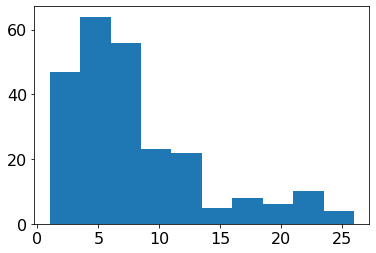

In [12]:
# save timept at which earliest diff emerges
#DIFF MOVIES 
earliest_pt_diff = np.empty((268,))
earliest_pt_diff [:] = np.nan
sign_earliest_pt_diff  = np.empty_like(earliest_pt_diff )
sign_earliest_pt_diff [:] = np.nan

ts = np.load(os.path.join(data_file_loc,'earliest_pt_div_diffmovies.npy'),allow_pickle=True)
print('ts[0][0]='+str(ts[0][0]))
nodes = np.arange(0,268)# np.arange(10)
for i_nodes,n in enumerate(nodes):
    if i_nodes % 50 ==0:
        print('node:',n)
    
    t_array = ts[n]
    
    if len(t_array)>1:
        for i in range(len(t_array[0])-1):
            diff_12 = (tcs_trial_z[:,n,int(t_array[0][i]+tr0_ind):,movie_ind_yes]-
            tcs_trial_z[:,n,int(t_array[0][i]+tr0_ind):,movie_ind_no])
            auc1 = np.array([np.trapz(np.abs(diff_12[s,:])) for s in range(tcs_trial_z.shape[0])])
            _,p = stats.ttest_1samp(auc1,0)            
            
            if (p<.05) and (t_array[0][i+1] - t_array[0][i] == 1):
                earliest_pt_diff[n]      = t_array[0][i]
                sign_earliest_pt_diff[n] = t_array[1][i]
                break
    else:
        ear = np.nan
    
plt.hist(earliest_pt_diff)

node: 0
node: 50
node: 100
node: 150
node: 200
node: 250


(array([ 5.,  2.,  1.,  1.,  5.,  6.,  6.,  8., 13., 58.]),
 array([ 3. ,  5.3,  7.6,  9.9, 12.2, 14.5, 16.8, 19.1, 21.4, 23.7, 26. ]),
 <BarContainer object of 10 artists>)

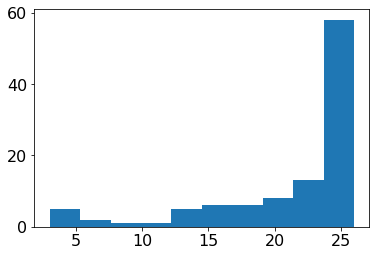

In [28]:
# save timept at which earliest diff emerges
#SAME MOVIE
earliest_pt_same = np.empty((268,))
earliest_pt_same [:] = np.nan
sign_earliest_pt_same  = np.empty_like(earliest_pt_same)
sign_earliest_pt_same [:] = np.nan

ts = np.load(os.path.join(data_file_loc,'earliest_pt_div_samemovie.npy'),allow_pickle=True)
nodes = np.arange(0,268)# np.arange(10)

for i_nodes,n in enumerate(nodes):
    if i_nodes % 50 ==0:
        print('node:',n)
    movieTC_yes = tcs_run_z[subs1,n,:,movie_ind_same] # nsubs * ntimepts
    movieTC_no = tcs_run_z[subs2,n,:,movie_ind_same] # nsubs * ntimepts

    t_array = ts[n]
    
    if len(t_array[0])>1: # if there is at least 2 timepts of divergence (1 could be by chance)
        for i in range(len(t_array[0])-1):
            
            tcn1 = tcs_run_z[subs1,n,int(t_array[0][i]+tr0_ind):,movie_ind_same]# subs * t:end
            tcn2 = tcs_run_z[subs2,n,int(t_array[0][i]+tr0_ind):,movie_ind_same]
            
            auc_y = np.array([np.trapz(tcn1[s,:]) for s in range(tcn1.shape[0])])
            auc_n = np.array([np.trapz(tcn2[s,:]) for s in range(tcn2.shape[0])])
            
            _,p = stats.ttest_ind(auc_y,auc_n,nan_policy='omit',equal_var=False)
            
            if p<.05 and (t_array[0][i+1] - t_array[0][i] == 1):
                earliest_pt_same[n]      = t_array[0][i]
                sign_earliest_pt_same[n] = t_array[1][i]
                break
            
plt.hist(earliest_pt_same)

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


diff vs. same movie: SpearmanrResult(correlation=-0.1222589545440126, pvalue=0.22323595027494486)
diff vs. all movies: SpearmanrResult(correlation=0.35859779734223346, pvalue=4.787196942446677e-08)


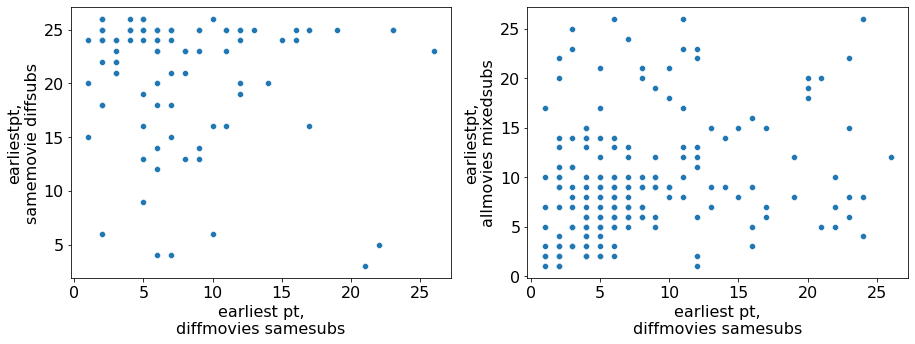

In [31]:
plt.figure(1,figsize =(15,5))
plt.subplot(1,2,1)
sns.scatterplot(earliest_pt_diff,earliest_pt_same)
plt.xlabel('earliest pt,\ndiffmovies samesubs')
plt.ylabel('earliestpt,\nsamemovie diffsubs')
print('diff vs. same movie:',stats.spearmanr(earliest_pt_diff,earliest_pt_same,nan_policy='omit'))

plt.subplot(1,2,2)
sns.scatterplot(earliest_pt_diff,earliest_pt_all)
plt.xlabel('earliest pt,\ndiffmovies samesubs')
plt.ylabel('earliestpt,\nallmovies mixedsubs')
print('diff vs. all movies:',stats.spearmanr(earliest_pt_diff,earliest_pt_all,nan_policy='omit'))


- Taking area and consecutive timepts' divergence criteria, diff and same don't correlate, but diff and all do - i.e., same nodes diverging early in coax vs. bill also diverge early across movies.
- next, let's plot timecourses of nodes which showed the somewhat similar divergence pts in the same vs. diff comparison

In [36]:
nodes=np.where(np.abs(earliest_pt_diff-earliest_pt_all)<1)[0] # nodes with somewhat similar divergence pts
print(len(nodes))

plt.figure(1,figsize=(15,15))
tr_dec = 5

for iearl,earliest_pt in enumerate([earliest_pt_diff,earliest_pt_same, earliest_pt_all]):
    if iearl ==0:
        tc1 = tcs_trial_z[:,:,:,movie_ind_yes]
        tc2 = tcs_trial_z[:,:,:,movie_ind_no]
        
    elif iearl == 1:
        tc1 = tcs_run_z[subs1,:,:,movie_ind_same]
        tc2 = tcs_run_z[subs2,:,:,movie_ind_same]
        
    elif iearl == 2:
        tc1 = tcs_trial_resh_yes
        tc2 = tcs_trial_resh_no
        
    
    for i,n in enumerate(nodes):
        roi = eval(shen268[str(int(n+1))][0])['name']
        print(n+1,roi)
        roi = roi.split(';')
        
        #plt.title('Node '+ str(n+1))
        '''if iearl ==0:
            plt.subplot(int(len(nodes)),3,i*3+1)
            tmt.ttest_diffmovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
            ymin,ymax =plt.ylim()
            plt.vlines(earliest_pt_diff[n]+tr0_ind,ymin,ymax,color = 'magenta')
            plt.title(str(earliest_pt_diff[n])+', Node '+ str(n+1) + ',\n'+'\n'.join(roi),fontsize = 12)
        elif iearl== 1:
            plt.subplot(int(len(nodes)),3,i*3+2)
            tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
            ymin,ymax =plt.ylim()
            plt.vlines(earliest_pt_same[n]+tr0_ind,ymin,ymax,color = 'magenta')
            plt.title(str(earliest_pt_same[n])+', Node '+ str(n+1) + ',\n'+'\n'.join(roi),fontsize = 12)
        else:
            plt.subplot(int(len(nodes)),3,i*3+3)
            tmt.ttest_samemovies(tc1[:,n,:],tc2[:,n,:],1,'both',0,tr0_ind)
            ymin,ymax =plt.ylim()
            plt.vlines(earliest_pt_all[n]+tr0_ind,ymin,ymax,color = 'magenta')
            plt.title(str(earliest_pt_all[n])+', Node '+ str(n+1) + ',\n'+'\n'.join(roi),fontsize = 12)
        '''
        
        
        
        
        
plt.tight_layout()

38
5 47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole
7 100.00% Frontal_Pole
25 76.80% Juxtapositional_Lobule_Cortex_(formerly_Supplementary_Motor_Cortex); 13.96% Precentral_Gyrus; 9.01% Cingulate_Gyrus_anterior_division
27 90.05% Precentral_Gyrus; 7.30% Postcentral_Gyrus
33 79.75% Postcentral_Gyrus; 20.25% Precentral_Gyrus
39 69.21% Postcentral_Gyrus; 25.06% Precentral_Gyrus; 5.61% Superior_Parietal_Lobule
40 62.08% Central_Opercular_Cortex; 30.21% Insular_Cortex; 6.46% Heschl's_Gyrus_(includes_H1_and_H2)
46 30.14% Parietal_Operculum_Cortex; 28.13% Planum_Temporale; 14.65% Supramarginal_Gyrus_posterior_division; 13.38% Supramarginal_Gyrus_anterior_division; 7.69% Superior_Temporal_Gyrus_posterior_division
48 66.63% Lateral_Occipital_Cortex_superior_division; 33.37% Angular_Gyrus
55 51.45% Inferior_Temporal_Gyrus_posterior_division; 48.41% Middle_Temporal_Gyrus_posterior_division
74 95.78% Lateral_Occipital_Cortex_i

<Figure size 1080x1080 with 0 Axes>

- prob not the most maningful way to compare across conditions. Better would be tofirst decide using diff movies and then verify on the same-movie condition (which has lower power)
- nevertheless, we can see here that the between movie differences we see for coax vs. bill also show up comparing across all yes and no responses

## Goals:

1. Next, I try to visualize the Social - Random's earliest divergence in a brainmap and plot the timeseries
2. In another notebook (part 3), I will try to characterize this difference, and also look at diffs at the median TRs, where that emerges and when that ends - also measure the differnces using AUC

## Plot earliest point on a brainmap

In [13]:
#import plotting functions

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import plot_glass_brain
#import nibabel as nib

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


lbl = [str.upper(x[0:4]) for x in vidnames]
#lbl

In [35]:
# shen ROIs to overlay on FSL to identify node numbers
# run this only to save a nifti image with all 268 Shen regions

'''img = roi_to_brain(pd.Series(np.arange(1,269)), mask_x)
img.plot(colorbar=True, title = 'Shen nodes', 
         symmetric_cbar = False,cmap = 'RdBu_r')

flname = f'shenROInr268.nii'
img.write(os.path.join(data_file_loc,'figures',flname))'''


"img = roi_to_brain(pd.Series(np.arange(1,269)), mask_x)\nimg.plot(colorbar=True, title = 'Shen nodes', \n         symmetric_cbar = False,cmap = 'RdBu_r')\n\nflname = f'shenROInr268.nii'\nimg.write(os.path.join(data_file_loc,'figures',flname))"

([<matplotlib.axis.XTick at 0x7f89b0171310>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

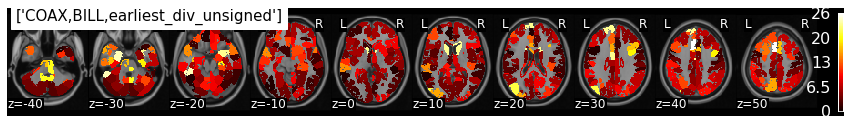

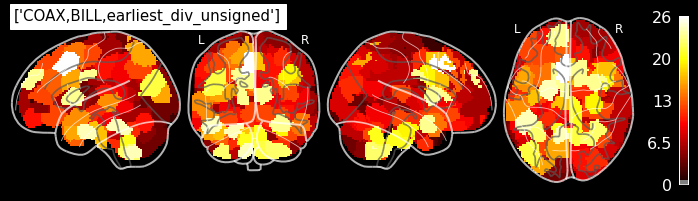

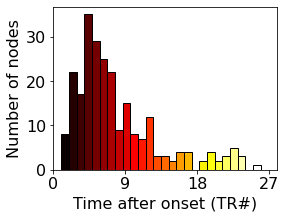

In [14]:
#plot earliest divergence point unsigned

img = roi_to_brain(pd.Series(earliest_pt_diff), mask_x)
txt = [lbl[movie_ind_yes]+','+lbl[movie_ind_no]+',earliest_div_unsigned']
img.plot(colorbar=True, title = txt, symmetric_cbar = False)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', colorbar = True, plot_abs=True, black_bg=True,threshold = 1)

img.write(os.path.join(data_file_loc,'figures',f'{txt}.nii'))

plt.figure(3,figsize = (4,3))
#sns.distplot(earliest_pt, bins = 27, label = 'sig nodes', norm_hist = False, color ='red')
# Plot histogram.
cm = plt.cm.get_cmap('hot')
n, bins, patches = plt.hist(earliest_pt_diff, int(np.nanmax(earliest_pt_diff)), edgecolor = 'k')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.ylabel('Number of nodes')
plt.xlabel('Time after onset (TR#)')
plt.xlim(0,28)
plt.xticks(np.arange(0,28,9))
#plt.legend()


In [25]:
df = pd.DataFrame({'t':earliest_pt_diff,'lbl':[eval(shen268[str(n+1)][0])['name'] for n in range(268)]})
df['hem'] = 'left'
df.iloc[:134,2] = 'right'
df = df.sort_values(by='t')
df.head(40)


,t,lbl,hem
139,1.0,59.08% Paracingulate_Gyrus; 22.05% Cingulate_Gyrus_anterior_division; 14.15% Frontal_Pole,left
205,1.0,55.19% Lateral_Occipital_Cortex_inferior_division; 29.41% Occipital_Fusiform_Gyrus; 8.65% Temporal_Occipital_Fusiform_Cortex; 6.75% Inferior_Temporal_Gyrus_temporooccipital_part,left
199,1.0,53.17% Temporal_Occipital_Fusiform_Cortex; 42.99% Inferior_Temporal_Gyrus_temporooccipital_part,left
50,1.0,99.23% Temporal_Pole,right
136,1.0,52.38% Frontal_Medial_Cortex; 27.72% Frontal_Pole; 12.59% Frontal_Orbital_Cortex; 7.31% Subcallosal_Cortex,left
156,1.0,50.95% Precentral_Gyrus; 27.86% Middle_Frontal_Gyrus; 21.19% Inferior_Frontal_Gyrus_pars_opercularis,left
191,1.0,52.60% Middle_Temporal_Gyrus_temporooccipital_part; 21.00% Supramarginal_Gyrus_posterior_division; 14.85% Middle_Temporal_Gyrus_posterior_division; 7.53% Superior_Temporal_Gyrus_posterior_division,left
53,1.0,44.25% Middle_Temporal_Gyrus_posterior_division; 31.27% Superior_Temporal_Gyrus_posterior_division; 19.17% Middle_Temporal_Gyrus_temporooccipital_part; 5.01% Supramarginal_Gyrus_posterior_division,right
142,2.0,100.00% Frontal_Pole,left
141,2.0,100.00% Frontal_Pole,left


In the figure, darker a region, earlier it shows a differential activation. Yellow regions showed a difference only later. Let's try to identify the earliest regions below

([<matplotlib.axis.XTick at 0x7fa6102cce50>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

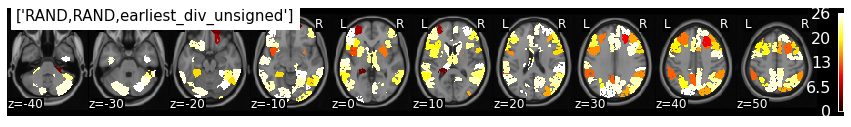

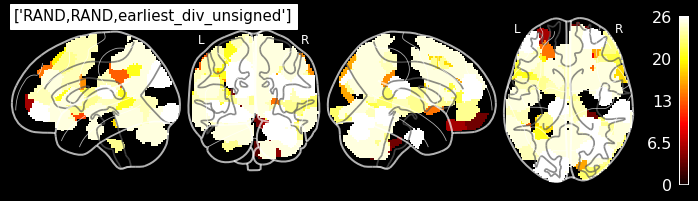

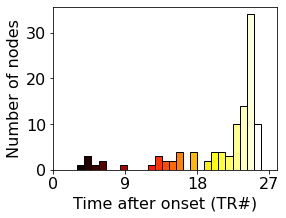

In [37]:
# but before that, plotting a simialr map for the same movie

#plot earliest divergence point unsigned SAME MOVIE
img = roi_to_brain(pd.Series(earliest_pt_same), mask_x)
txt = [lbl[movie_ind_same]+','+lbl[movie_ind_same]+',earliest_div_unsigned']
img.plot(colorbar=True, title = txt, symmetric_cbar = False)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', colorbar = True, plot_abs=True, black_bg=True)

img.write(os.path.join(data_file_loc,'figures',f'{txt}.nii'))

plt.figure(3,figsize = (4,3))
#sns.distplot(earliest_pt, bins = 27, label = 'sig nodes', norm_hist = False, color ='red')
# Plot histogram.
cm = plt.cm.get_cmap('hot')
n, bins, patches = plt.hist(earliest_pt_same, int(np.nanmax(earliest_pt_same)), edgecolor = 'k')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.ylabel('Number of nodes')
plt.xlabel('Time after onset (TR#)')
plt.xlim(0,28)
plt.xticks(np.arange(0,28,9))
#plt.legend()



([<matplotlib.axis.XTick at 0x7fa60028b8d0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

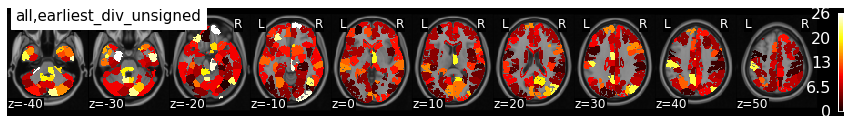

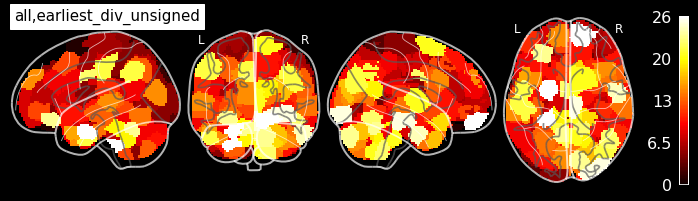

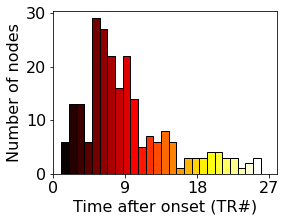

In [38]:
# all movies

img = roi_to_brain(pd.Series(earliest_pt_all), mask_x)
txt = 'all,earliest_div_unsigned'
img.plot(colorbar=True, title = txt, symmetric_cbar = False)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', colorbar = True, plot_abs=True, black_bg=True)

img.write(os.path.join(data_file_loc,'figures',f'{txt}.nii'))

plt.figure(3,figsize = (4,3))
#sns.distplot(earliest_pt, bins = 27, label = 'sig nodes', norm_hist = False, color ='red')
# Plot histogram.
cm = plt.cm.get_cmap('hot')
n, bins, patches = plt.hist(earliest_pt_all, int(np.nanmax(earliest_pt_all)), edgecolor = 'k')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.ylabel('Number of nodes')
plt.xlabel('Time after onset (TR#)')
plt.xlim(0,28)
plt.xticks(np.arange(0,28,9))
#plt.legend()



- to be clear, this is a visualization of the correlation plots. imo it's easier to look at the correlation plots. alternatively we can also look at differences at the earliest possible decision timept (during which most movies/subs wouldbe in the process of decision-making).

## Signed Yes vs. No

- same as above, but with signs of differences at the divergence pts

/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


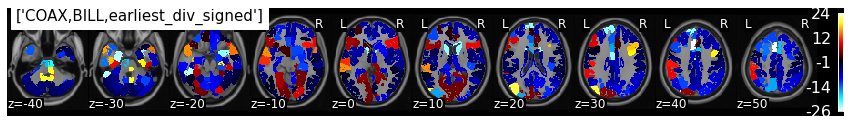

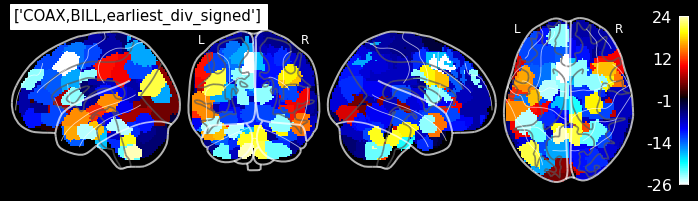

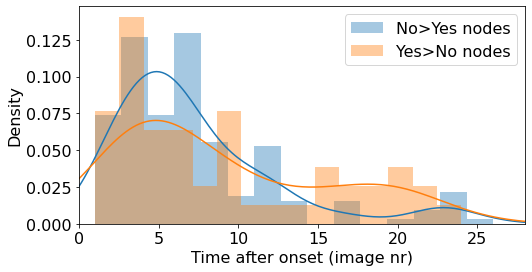

In [125]:
# plot magnitude and direction of divergence
# DIFF MOVIES

img = roi_to_brain(pd.Series(np.multiply(earliest_pt_diff,sign_earliest_pt_diff)), mask_x)

txt = [lbl[movie_ind_yes]+','+lbl[movie_ind_no]+',earliest_div_signed']

img.plot(colorbar=True, title = txt, symmetric_cbar = False)#,cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(),title = txt,display_mode='lyrz', 
                 symmetric_cbar = False,black_bg=True,colorbar = True, plot_abs=False)

img.write(os.path.join(data_file_loc,'figures', f'{txt}.nii'))

plt.figure(3,figsize = (8,4))
sns.distplot(earliest_pt_diff[sign_earliest_pt_diff < 0], bins = 15, label = 'No>Yes nodes', norm_hist = False)
sns.distplot(earliest_pt_diff[sign_earliest_pt_diff > 0], bins = 15, label = 'Yes>No nodes', norm_hist = False)
plt.xlabel('Time after onset (image nr)')
plt.xlim(0,28)
plt.legend()



/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


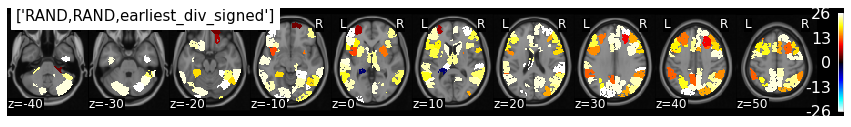

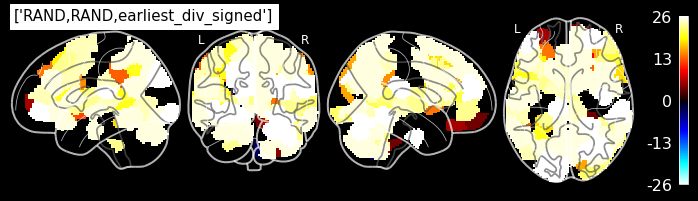

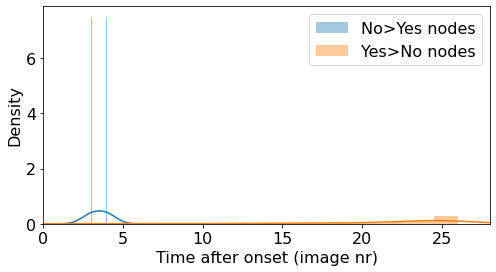

In [128]:
# plot magnitude and direction of divergence
#SAME MOVIE

img = roi_to_brain(pd.Series(np.multiply(earliest_pt_same,sign_earliest_pt_same)), mask_x)

txt = [lbl[movie_ind_same]+','+lbl[movie_ind_same]+',earliest_div_signed']

img.plot(colorbar=True, title = txt, symmetric_cbar = True)
plot_glass_brain(img.to_nifti(),title = txt,display_mode='lyrz', symmetric_cbar = True,
                 black_bg=True,colorbar = True, plot_abs=False)

img.write(os.path.join(data_file_loc,'figures', f'{txt}.nii'))

plt.figure(3,figsize = (8,4))
sns.distplot(earliest_pt_same[sign_earliest_pt_same < 0], bins = 15, label = 'No>Yes nodes', norm_hist = False)
sns.distplot(earliest_pt_same[sign_earliest_pt_same > 0], bins = 15, label = 'Yes>No nodes', norm_hist = False)
plt.xlabel('Time after onset (image nr)')
plt.xlim(0,28)
plt.legend()




## Signed timepts of divergence (same as above), but here signs are assigned based on absolute values 
    - E.g. warm colors if abs(yes)> abs(no)

In [89]:

yes_dirn = np.empty((268,))
yes_dirn[:] = np.nan
no_dirn = np.empty_like(yes_dirn)
no_dirn[:] = np.nan
for n in range(268):
    if ~np.isnan(earliest_pt[n]):
        t = int(earliest_pt[n] + tr0_ind)
        yes_dirn[n] = np.nanmedian(tc_all[:,n,t,movie_ind_yes],axis =0) # nodes
        no_dirn[n]  = np.nanmedian(tc_all[:,n,t,movie_ind_no],axis =0)# nodes 

        
mag_sign = np.empty((268,))
mag_sign[:] = np.nan
abs_diff = np.abs(yes_dirn) - np.abs(no_dirn)
abs_diff[np.abs(abs_diff)< 1e-5] =0
mag_sign[abs_diff > 0] =  1
mag_sign[abs_diff < 0] = -1

np.where(~np.isnan(mag_sign))[0].shape

(253,)

/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


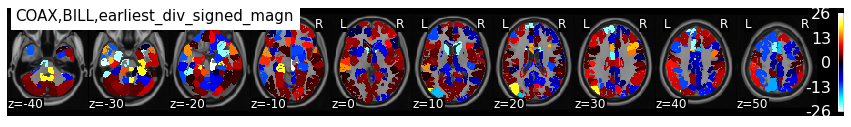

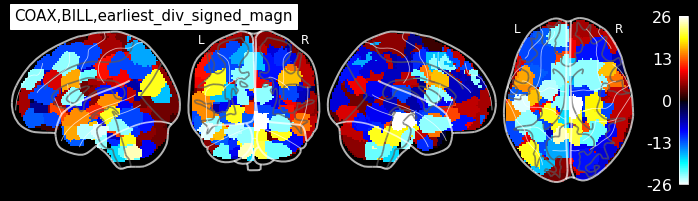

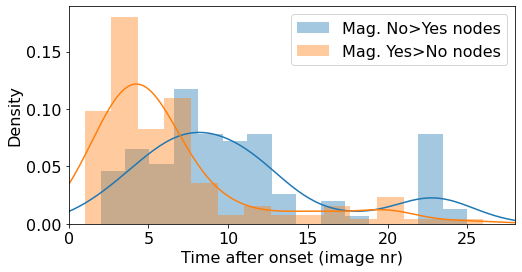

In [90]:
# plot magnitude and direction of divergence

img = roi_to_brain(pd.Series(np.multiply(earliest_pt,mag_sign)), mask_x)

txt = lbl[movie_ind_yes]+','+lbl[movie_ind_no]+',earliest_div_signed_magn'


img.plot(colorbar=True, title = txt, symmetric_cbar = True)
plot_glass_brain(img.to_nifti(),title = txt,display_mode='lyrz', black_bg=True, symmetric_cbar = True,colorbar = True, plot_abs=False)

img.write(os.path.join(data_file_loc,'figures', txt + '.nii'))

plt.figure(3,figsize = (8,4))
sns.distplot(earliest_pt[mag_sign < 0], bins = 15, label = 'Mag. No>Yes nodes', norm_hist = False)
sns.distplot(earliest_pt[mag_sign > 0], bins = 15, label = 'Mag. Yes>No nodes', norm_hist = False)
plt.xlabel('Time after onset (image nr)')
plt.xlim(0,28)
plt.legend()


- Histogram: earliest changes are social > random, random>social has two waves:centred around 8 and then then 22
- early social activity in lateral cerebellum, 

59.08% Paracingulate_Gyrus; 22.05% Cingulate_Gyrus_anterior_division; 14.15% Frontal_Pole


NameError: name 'tc_all' is not defined

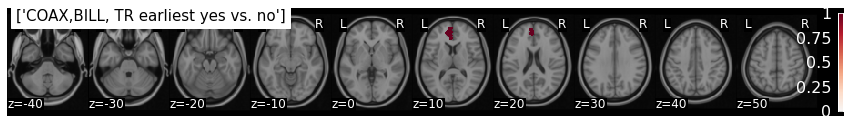

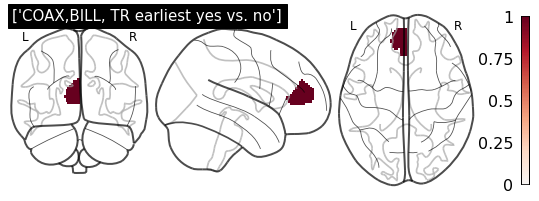

<Figure size 432x288 with 0 Axes>

In [39]:
# sanity check: plotting an roi.

node = np.empty((268,))
node[:] = np.nan
n = 139
node[n] = 1
nt = movieTC_yes.shape[-1]
print(eval(shen268[str(n+1)][0])['name'])

tdiv1 = np.empty((268,))
tdiv1[:] = np.nan
tdiv1[n] = 1#earliest_pt[n] * mag_sign[n] if earliest_pt[n] * mag_sign[n]!=0 else 1
                
img = roi_to_brain(pd.Series(tdiv1), mask_x)
img.plot(colorbar=True, title = [lbl[movie_ind_yes]+','+lbl[movie_ind_no]+', TR earliest yes vs. no'], 
         symmetric_cbar = False,cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(),title = [lbl[movie_ind_yes]+','+lbl[movie_ind_no]+', TR earliest yes vs. no'],
                         symmetric_cbar = False,cmap = 'RdBu_r',colorbar = True, plot_abs=False)


plt.figure(3)
movieTC_yes = tc_all[:,n,:,movie_ind_yes] # nsubs * ntimepts
movieTC_no = tc_all[:,n,:,movie_ind_no] # nsubs * ntimepts
ts = responses_ttest(movieTC_yes,movieTC_no,1, "both")

'''plt.figure(4)
plt.errorbar(np.arange(nt),np.nanmedian(movieTC_yes,axis=0),
                         stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = 'r')
plt.errorbar(np.arange(nt),np.nanmedian(movieTC_no,axis=0),
                         stats.sem(movieTC_no,axis=0,nan_policy='omit'),color = 'b')
ymin,ymax = plt.ylim()
plt.title('Node '+str(n+1))
plt.vlines(earliest_pt[n]+3,ymin,ymax, color = 'magenta')
plt.xticks(np.arange(0,32,6),[str(i) for i in np.arange(-3,28,6)])'''


- Next, I will plot the significant nodes sorted early to late

# Extra: these analyses could be useful to look into differences at some point.  (need to refine)

## Only for diff (coax vs bill) movies

In [137]:
# Part 1: Sorting the node
# a: assign nodes_unsorted with values: earliest timept * sign. insig nodes = nan
timepts_unsorted = np.multiply(earliest_pt_diff,sign_earliest_pt_diff)
timepts_unsorted[timepts_unsorted==0] = np.nan
#timepts_unsorted_magsign = np.multiply(earliest_pt,mag_sign)

# b: sorted, unsigned
nodes_order_unsigned = np.argsort(np.abs(timepts_unsorted))
#print('\nsorted nodes (unsigned):',nodes_order_unsigned) 
timepts_sorted_unsigned = timepts_unsorted[nodes_order_unsigned]
print('\nsorted timepts (unsigned):',timepts_sorted_unsigned) # sanity check

# c: sorted, signed
nodes_order_signed = np.argsort(timepts_unsorted)
#print('\nsigned:',nodes_order_signed)
timepts_sorted_signed = timepts_unsorted[nodes_order_signed]
print('signed node timepts:',timepts_sorted_signed)


# d: sorted, magsigned
#nodes_order_magsigned = np.argsort(timepts_unsorted_magsign)
#print('\nmag signed:',nodes_order_magsigned)




sorted timepts (unsigned): [ -1.  -1.  -1.   1.   1.  -1.  -1.  -1.  -2.  -2.  -2.  -2.  -2.   2.
  -2.   2.  -2.   2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
   2.  -2.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.   3.  -3.  -3.
  -3.  -3.  -3.  -3.  -3.  -4.   4.   4.  -4.  -4.  -4.  -4.  -4.  -4.
  -4.   4.   4.   4.   4.   4.  -4.  -4.   4.  -4.  -4.  -4.  -4.  -4.
  -4.  -4.  -4.  -4.  -4.   4.  -4.   4.  -4.  -4.  -4.  -4.  -5.  -5.
  -5.   5.  -5.   5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.   5.   5.  -5.
   5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.   6.
  -6.  -6.  -6.  -6.  -6.   6.  -6.   6.  -6.  -6.  -6.  -6.  -6.  -6.
  -6.  -6.  -6.  -6.  -6.   6.  -6.  -6.  -6.  -6.  -7.  -7.  -7.  -7.
  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -7.   7.  -7.
  -7.  -7.  -7.  -7.   8.  -8.  -8.  -8.  -8.  -8.   8.  -8.  -8.  -9.
  -9.  -9.  -9.   9.  -9.   9.  -9.   9.   9.  -9.  -9.  -9.  -9.  -9.
 -10. -10. -10.  10. -10. -10. -10.  10. -11. -11

In [ ]:
# Plot divergence points, sorted from earliest to latest

ncols = 5
nrows = int(np.ceil(len(np.where(~np.isnan(timepts_unsorted))[0])/ncols))
nt = 32
plt.figure(1,figsize = (15,100))
for i,n in enumerate(nodes_order_unsigned): #plot early to late
    if ~np.isnan(timepts_unsorted[n]):
        tdiv = earliest_pt_diff[n] # earliest timept of divergence
        plt.subplot(nrows,ncols,i+1)
        movieTC_yes = tcs_run_z[:,n,:,movie_ind_yes] # nsubs * ntimepts
        movieTC_no = tcs_run_z[:,n,:,movie_ind_no] # nsubs * ntimepts
        plt.errorbar(np.arange(nt),np.nanmedian(movieTC_yes,axis=0),
                                 stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = 'r')
        plt.errorbar(np.arange(nt),np.nanmedian(movieTC_no,axis=0),
                                 stats.sem(movieTC_yes,axis=0,nan_policy='omit'),color = 'b')
        ymin,ymax = plt.ylim()
        plt.vlines(tdiv+tr0_ind,ymin,ymax, color = 'magenta')
        plt.xticks(np.arange(0,nt-2,10),np.arange(0,nt-2,10)-3)
        plt.vlines(3,ymin,ymax, color = 'k')
        plt.hlines(0,0,32, color = 'k')
        plt.title(f'Node {n+1},t={timepts_unsorted[n]}') # check if this is correct again!!
    
plt.tight_layout()

In [141]:
df = pd.DataFrame({'node':nodes_order_unsigned,
                   'timept': timepts_sorted_unsigned, 
                   'yes-no': np.round(yes_dirn[nodes_order_unsigned]-no_dirn[nodes_order_unsigned],2),
                   'ROI':[eval(shen268[str(i+1)][0])['name'].split(';')[0] for i in nodes_order_unsigned]})
df = df.loc[~np.isnan(df['timept']),:]
df.head(268)

NameError: name 'yes_dirn' is not defined

In [140]:
# plotting maps of 4 bins
nrows = int(np.ceil(df.shape[0]/4))
for i in range(4):
    inds = np.arange(i*nrows,(i+1)*nrows)
    if i == 3:
        inds = inds[inds<df.shape[0]]
    tinds = df['node'].values[inds]
    mint = min(np.abs(df['timept'].values[inds]))
    maxt = max(np.abs(df['timept'].values[inds]))
    print(f'bin {i}, min: {mint},max: {maxt}')
    t = np.empty((268,))
    t[:] = np.nan
    #t[tinds] = np.abs(df.iloc[inds,2].values)
    t[tinds] = df.iloc[inds,2].values
    
    img = roi_to_brain(pd.Series(t), mask_x)
    txt = f'{lbl[movie_ind_yes]},{lbl[movie_ind_no]}, bin {i}'
    img.plot(colorbar=True, title = txt, 
             symmetric_cbar = False,cmap = 'RdBu_r')
    plot_glass_brain(img.to_nifti(),title = txt,  display_mode='lyrz',
                             symmetric_cbar = False,cmap = 'RdBu_r',colorbar = True, plot_abs=False)


NameError: name 'df' is not defined

In [ ]:
# split nodes into 4 bins, print timepts, median diff and ROI names for each node
print('1:',df.iloc[:int(df.shape[0]/4),:].values)
print('\n2:',df.iloc[int(df.shape[0]/4):int(df.shape[0]/2),-3:].values)
print('\n3:',df.iloc[int(df.shape[0]/2):int(3*df.shape[0]/4),-3:].values)
print('\n4:',df.iloc[int(3*df.shape[0]/4):,-3:].values)

In [ ]:
plt.figure(1,figsize = (15,4))
#plt.hlines(0,0,200)
plt.bar(range(df.shape[0]),np.abs(df['yes-no']))
# result shows that there is no change in magnitude over time for first diffs

# Difference at the median decision time!!

## Qn: Which ROIs show a difference at the median RT?

In [142]:
# median decision RT from the online expt
t_secs = np.array([3.49,3.77, 6.02]) # COAX, BILL. RAND: 6.02s "no" responses, 13.87s for "yes" responses
TR = .72 #secs
t_TRs_ind = np.ceil((t_secs/TR)-1)
print(t_TRs_ind)
t_TRs_ind += 3 # add three to account for the prestim baseline

[4. 5. 8.]


- from the figure above (red = median social > nonsocial, color indicatesthe magnitude of differnce), it looks like most of the diffs at t approx.= 3secs is negative, i.e, social <nonsocial. Is this due to a dip in social or activation in random? let's compare absolute values at this point next.

In [202]:
tmedian = np.empty((268,))
tmedian[:] = np.nan
pmedian = np.empty_like(tmedian)
pmedian[:] = np.nan
median_diff = np.empty_like(tmedian)
median_diff[:] = np.nan
yes_no_sign = np.empty_like(tmedian)
yes_no_sign[:] = np.nan
for n in range(268):
    tmedian[n],pmedian[n] = \
        stats.ttest_rel(movie_tc_yes[:,n,int(t_TRs_ind[1])],
                        movie_tc_no[:,n,int(t_TRs_ind[1])],nan_policy='omit')
    yes_med = np.nanmedian(movie_tc_yes[:,n,int(t_TRs_ind[1])])
    no_med = np.nanmedian(movie_tc_no[:,n,int(t_TRs_ind[1])])
                           
    median_diff[n] = yes_med - no_med
    if abs(abs(yes_med) - abs(no_med)) > 1e-5:
        if abs(yes_med) > abs(no_med):
               yes_no_sign[n] = 1
        elif abs(yes_med) < abs(no_med):
                yes_no_sign[n] = -1
    else:
        yes_no_sign[n] = 0

#consistentsy test:

for n in np.where(pmedian <.05)[0]:
    if ((len(np.where(ts_all[0][n][0] == int(t_TRs_ind[1]-tr0_ind)-1)[0])==0) and \
        (len(np.where(ts_all[0][n][0] == int(t_TRs_ind[1]-tr0_ind)+1)[0])==0)):
        pmedian[n] =np.nan
        tmedian[n] = np.nan
        
print(np.where(pmedian<.05))

tdiv_med = np.empty((268,))
tdiv_med[:] = np.nan
sign_diff = np.empty((268,))
sign_diff[:] = np.nan
ct = 1
for n in np.where(pmedian<.05)[0]:
    TRs = np.arange(1, max(t_TRs_ind))
    TRs = TRs[::-1]
    #print(TRs)
    supra_thresh_ct = 0
    for t in TRs:
        t = int(t)
        _, pval = stats.ttest_rel(movie_tc_yes[:,n,t],
                        movie_tc_no[:,n,t],nan_policy='omit')
        #print(n,t,pval)
        sign_diff = 1 if np.sign(np.nanmedian(movie_tc_yes[:,n,t]-movie_tc_no[:,n,t])) == \
        np.sign(np.nanmedian(movie_tc_yes[:,n,int(min(t_TRs_ind))]-movie_tc_no[:,n,int(min(t_TRs_ind))])) \
        else -1
        #print(t,pval,sign_diff)
        if (pval >= .05) | (sign_diff==-1):
            supra_thresh_ct += 1
        if supra_thresh_ct == ct:
            tdiv_med[n] = t+ct
            break
    
        
tdiv_med -= 3
tdiv_med

(array([  8,  12,  20,  22,  23,  24,  25,  26,  32,  33,  34,  36,  37,
        38,  39,  40,  41,  43,  44,  45,  50,  51,  53,  56,  62,  64,
        65,  66,  67,  68,  70,  71,  72,  73,  78,  79,  80,  81,  86,
        96,  99, 104, 110, 111, 113, 115, 121, 125, 136, 137, 142, 154,
       157, 158, 159, 161, 162, 164, 167, 169, 171, 172, 173, 174, 179,
       180, 182, 191, 199, 204, 205, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 217, 222, 224, 225, 235, 237, 240, 241, 245, 246, 249,
       251, 252, 253, 256, 259]),)


array([nan, nan, nan, nan, nan, nan, nan, nan,  5., nan, nan, nan,  5.,
       nan, nan, nan, nan, nan, nan, nan,  2., nan,  3.,  3.,  5.,  5.,
        2., nan, nan, nan, nan, nan,  2.,  5.,  4., nan,  5.,  4.,  5.,
        4.,  4.,  5., nan,  5.,  4.,  2., nan, nan, nan, nan,  1.,  2.,
       nan,  1., nan, nan,  5., nan, nan, nan, nan, nan,  5., nan,  2.,
        2.,  2.,  4.,  3., nan,  1.,  4.,  5.,  3., nan, nan, nan, nan,
        4.,  4.,  3.,  4., nan, nan, nan, nan,  4., nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  5., nan, nan,  5., nan, nan, nan, nan,
        3., nan, nan, nan, nan, nan,  3.,  4., nan,  5., nan,  5., nan,
       nan, nan, nan, nan,  5., nan, nan, nan,  5., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan,  2.,  5., nan, nan, nan, nan,  2.,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  5., nan,
       nan,  5.,  3.,  4., nan,  2.,  4., nan,  3., nan, nan,  3., nan,
        5., nan,  4.,  5.,  4.,  4., nan, nan, nan, nan,  3.,  3

In [ ]:
img = roi_to_brain(pd.Series(tdiv_med), mask_x)
txt = f'tmedian_div_emergence'
img.plot(colorbar=True, title = txt, 
         symmetric_cbar = False)
plot_glass_brain(img.to_nifti(),title = txt,
                         symmetric_cbar = False,colorbar = True,display_mode='lyrz', black_bg = True, plot_abs=False)

#flname = f'{txt}.nii'
#img.write(os.path.join(data_file_loc,'figures',flname))



## find timepoint of flip

([<matplotlib.axis.XTick at 0x7f8413d129a0>,
 [Text(0, 0, '-3'),
  Text(4, 0, '1'),
  Text(8, 0, '5'),
  Text(12, 0, '9'),
  Text(16, 0, '13'),
  Text(20, 0, '17'),
  Text(24, 0, '21'),
  Text(28, 0, '25')])

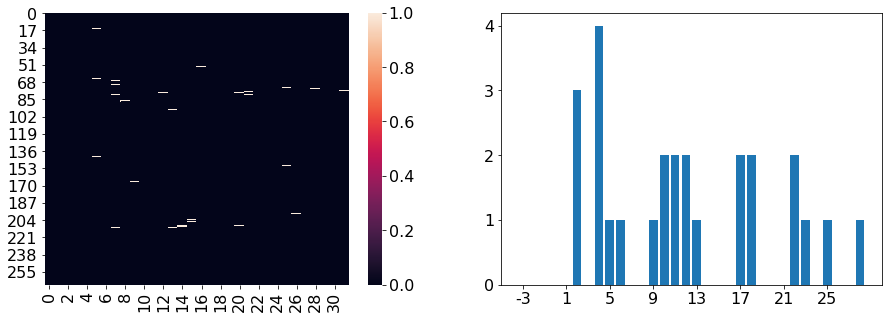

In [309]:
flips = np.zeros((268,32))

for n in range(268):
    mean_diff = np.nanmean(tc_all[:,n,3:,movie_ind_yes]-tc_all[:,n,3:,movie_ind_no],axis =0)
    #print(mean_diff)
    for t in np.arange(1,len(mean_diff)):
        prev = stats.ttest_1samp(tc_all[:,n,t-1+tr0_ind,movie_ind_yes]-
                                   tc_all[:,n,t-1+tr0_ind,movie_ind_no],0)
        curr = prev = stats.ttest_1samp(tc_all[:,n,t+tr0_ind,movie_ind_yes]-
                                          tc_all[:,n,t+tr0_ind,movie_ind_no],0)
        
        if (np.sign(mean_diff[t-1]) != np.sign(mean_diff[t])) and \
        (np.sign(mean_diff[t-1]) != 0) and (np.sign(mean_diff[t]) != 0) and \
        (prev.pvalue <.05) and (curr.pvalue<.05) :
            flips[n,t + tr0_ind] = 1

plt.figure(1,figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(flips)

plt.subplot(1,2,2)
plt.bar(range(32),np.sum(flips,axis=0))
plt.xticks(np.arange(0,32,4),[str(i) for i in np.arange(0,32,4)-tr0_ind])

## Count flips

In [729]:
np.where(np.diff(np.sign(diff_median[88,3:])))[0]

array([ 0,  1,  2,  8, 11, 12, 13, 15, 19, 20, 22, 23, 24, 25, 26])

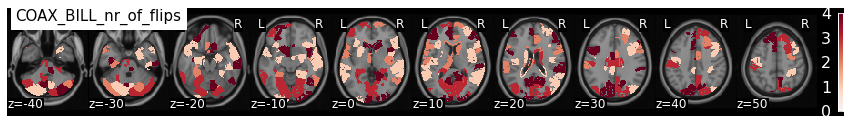

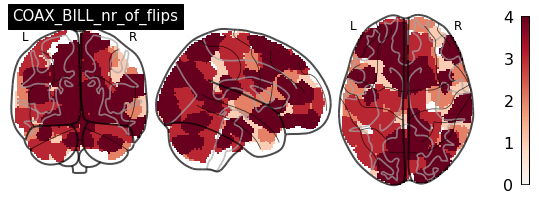

In [733]:
count_flips = np.empty((268,))
count_flips[:] = np.nan
diff_median = np.nanmedian(movie_tc_yes-movie_tc_no,axis=0) # 268*32

for n in range(268):
    count_flips[n] = len(np.where(np.diff(np.sign(diff_median[n,3:])))[0])
count_flips[count_flips>4]=np.nan
img = roi_to_brain(pd.Series(count_flips), mask_x)
txt = f'{lbl[movie_ind_yes]}_{lbl[movie_ind_no]}_nr_of_flips'
img.plot(colorbar=True, title = txt, symmetric_cbar = False,cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,cmap = 'RdBu_r',colorbar = True, 
                 plot_abs=False)

flname = f'{txt}.nii'
img.write(os.path.join(data_file_loc,'figures',flname))



- here we can see that although several nodes show Yes> No in the end, there is often a yes-to-no flip (e.g. yes>no at t=28, but no>yes at t=10). To identify these and other diffs, next analyses:

1. identify accumulators, deciders etc. using all movies' data
2. use these labels to split nodes
3. also split nodes where activity flips from no>yes to yes>no

# Extra code

In [ ]:

#Nodes diverging at TR=1
# very interesting, but not immediately relevant, since we're planning to focus on TR=5, and pre and post TR=5 for now

for i,earliest_pt in enumerate([earliest_pt_diff,earliest_pt_same]):
    
    
    one_div_nodes = np.where(earliest_pt==1)[0]
    print(one_div_nodes) # nr of nodes with differences at t = 1

    #plot earliest divergence point unsigned
    earliest1 = np.zeros((268,))
    earliest1[earliest_pt==1] = 1

    img = roi_to_brain(pd.Series(earliest1), mask_x)
    suff = ['same','diff']
    txt = "TR=1," + suff[i] + 'movie'
    img.plot(colorbar=True, title = txt)
    #img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
    plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                     display_mode='lyrz',black_bg=True)



In [ ]:
# plotting the nodes that diverge early for the different movie comparison

plt.figure(1,figsize = (15,50))
for i,n in enumerate(np.where(earliest_pt_diff==1)[0]):
    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    print(n+1, roi)
    plt.subplot(8,2,i*2+1)
    plt.title('Diff, Node '+ str(n+1) + ',('+ ['Right' if n<134 else 'Left'][0] + '),\n'+'\n'.join(roi),
             fontsize =16)
    tmt.ttest_diffmovies(tcs_trial_z[:,n,:,movie_ind_yes],tcs_trial_z[:,n,:,movie_ind_no],1,'both')
    
    plt.subplot(8,2,i*2+2)
    plt.title('Same,Node '+ str(n+1) + ',('+ ['Right' if n<134 else 'Left'][0] + '),\n'+'\n'.join(roi),
             fontsize =16)
    tmt.ttest_samemovies(tcs_run_z[subs1,n,:,movie_ind_same],tcs_run_z[subs2,n,:,movie_ind_same],1,'both')
    
    
plt.tight_layout()

In [ ]:
# plotting the nodes that diverge early for the same movie comparison
plt.figure(1,figsize = (15,50))
for i,n in enumerate(np.where(earliest_pt_same==1)[0]):
    if i > 7:
        break
    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    print(n+1, roi)
    plt.subplot(8,2,i*2+1)
    plt.title('Diff, Node '+ str(n+1) + ',('+ ['Right' if n<134 else 'Left'][0] + '),\n'+'\n'.join(roi),
             fontsize =16)
    tmt.ttest_diffmovies(tcs_trial_z[:,n,:,movie_ind_yes],tcs_trial_z[:,n,:,movie_ind_no],1,'both')
    
    plt.subplot(8,2,i*2+2)
    plt.title('Same,Node '+ str(n+1) + ',('+ ['Right' if n<134 else 'Left'][0] + '),\n'+'\n'.join(roi),
             fontsize =16)
    tmt.ttest_samemovies(tcs_run_z[subs1,n,:,movie_ind_same],tcs_run_z[subs2,n,:,movie_ind_same],1,'both')
    
    
plt.tight_layout()

In [ ]:
plt.figure(1,figsize = (15,15))
for i,n in enumerate(one_div_nodes):
    plt.subplot(4,2,i+1)
    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    print(n+1, roi)
    plt.title('Node '+ str(n+1) + ',('+ ['Right' if n<134 else 'Left'][0] + '),\n'+'\n'.join(roi),
             fontsize =16)
    responses_ttest(tc_all[:,n,:,0],tc_all[:,n,:,1],'both')
plt.tight_layout()

In [ ]:
# plotting 
#plot earliest divergence point unsigned
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

earliest5 = np.zeros((268,))
earliest5[earliest_pt<=5] = earliest_pt[earliest_pt<=5]
earliest5[earliest_pt>5] = 0


img = roi_to_brain(pd.Series(earliest5), mask_x)
txt = "Earliest emerging TR<=5"
img.plot(colorbar=True, title = txt, symmetric_cbar = False)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', colorbar = True, plot_abs=True, black_bg=True)



In [ ]:
# earliestdiv late (TR>18, 18 chosen arbitrarily)

#latest nodes
# plotting 
#plot earliest divergence point unsigned
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

earliest18 = np.zeros((268,))
earliest18[earliest_pt>18] = earliest_pt[earliest_pt>18]

img = roi_to_brain(pd.Series(earliest18), mask_x)
txt = "TR>18"
img.plot(colorbar=True, title = txt)
#img = roi_to_brain(pd.Series(earliest_pt-max(earliest_pt)), mask_x)
plot_glass_brain(img.to_nifti(),title = txt, symmetric_cbar = False,
                 display_mode='lyrz', plot_abs=True, colorbar = True, black_bg=True)


#print([[i,earliest_pt[i],eval(shen268[str(int(i+1))][0])['name']] for i in range(268) if earliest_pt[i]>18])

nodes = np.where(earliest_pt>18)[0]
print(len(nodes))
plt.figure(1,figsize = (30,20))

for i,n in enumerate(nodes):
    plt.subplot(5,5,i+1)
    #plt.title('Node '+ str(n+1))
    roi = eval(shen268[str(int(n+1))][0])['name'].split(';')
    print(n+1,roi)
    plt.title('Node '+ str(n+1) + ',\n'+'\n'.join(roi),fontsize = 20)
    responses_ttest(tc_all[:,n,:,0],tc_all[:,n,:,1],'both')
    ymin,ymax =plt.ylim()
    plt.vlines(earliest_pt[n]+tr0_ind,ymin,ymax,color = 'magenta')
plt.tight_layout()